In [1]:
import pandas as pd
import numpy as np
import os
import json
from video_process_utils import *
from keras.models import load_model
import keras.losses
import keras.metrics
keras.losses.loss = keras.losses.mse
keras.metrics.loss = keras.metrics.mse
from IPython.display import Video
from statsmodels.regression.linear_model import OLSResults

In [2]:
path = "out/07337701-processed/"


In [3]:
def convert_json2csv(json_dir):
    resL = np.zeros((2000,75))
    resL[:] = np.nan 


    # #rename all files name in folder 
    # folder = "Data/41438708-processed"
    # for count, filename in enumerate(os.listdir(folder)):
    #     dst = f"41438708-processed_{str(count)}_keypoints.json"
    #     src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
    #     dst =f"{folder}/{dst}"
    #     os.rename(src, dst)

    for frame in range(1,2000):
        test_image_json = '%s07337701-processed_%s_keypoints.json' %\
            (json_dir, str(frame).zfill(12))
        if not os.path.isfile(test_image_json):
            break
        with open(test_image_json) as data_file:  
            data = json.load(data_file)

        for person in data['people']:
            keypoints = person['pose_keypoints_2d']
            xcoords = [keypoints[i] for i in range(len(keypoints)) if i % 3 == 0]
            counter = 0
            resL[frame-1,:] = keypoints
            break
    check = np.apply_along_axis(lambda x: np.any(~np.isnan(x)),1,resL)
    for i in range(len(check)-1,-1,-1):
        if check[i]:
            break
    return resL[:i+1]

In [4]:
frames = convert_json2csv(path)
frames = frames[~np.isnan(frames).any(axis=1)]
pd.DataFrame(frames)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,172.774,71.00330,0.798969,168.886,89.2196,0.901933,150.542,89.2600,0.901885,140.101,...,0.852466,145.374,238.048,0.746293,140.178,235.411,0.793903,151.926,234.067,0.724578
1,170.196,68.43380,0.727172,168.862,89.2353,0.889918,150.527,89.2893,0.887214,138.832,...,0.761059,146.667,238.057,0.743993,140.208,235.418,0.798251,151.939,232.823,0.732231
2,168.855,68.35480,0.722759,168.864,87.9702,0.896965,149.308,87.9965,0.906924,138.855,...,0.748690,146.657,236.787,0.729208,140.205,235.393,0.792631,151.916,232.815,0.744149
3,171.443,68.36780,0.755667,168.858,87.9236,0.889590,150.527,87.9355,0.904952,138.853,...,0.733041,144.096,238.049,0.731308,140.171,235.401,0.802520,151.901,232.817,0.754289
4,172.809,68.34910,0.825209,168.858,87.9153,0.886356,149.302,87.9303,0.893594,138.806,...,0.750642,145.381,238.055,0.730546,140.183,235.421,0.807080,151.875,232.839,0.745752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,180.603,3.72420,0.820380,179.285,27.8842,0.844921,144.095,27.9546,0.784430,127.079,...,0.764240,140.140,286.307,0.699348,137.518,281.113,0.644722,154.503,278.544,0.713807
595,174.124,3.73427,0.529579,178.011,26.5867,0.837381,142.767,26.6561,0.800259,130.992,...,0.709918,140.125,286.307,0.705120,136.253,281.118,0.656999,154.517,278.549,0.710774
596,174.096,3.73502,0.481612,175.397,25.2472,0.805127,141.427,25.2967,0.829326,121.914,...,0.710843,140.184,286.315,0.686299,137.557,282.397,0.662731,153.241,279.838,0.697462
597,172.809,3.74131,0.276136,175.394,22.7097,0.794505,141.422,23.9431,0.803045,123.165,...,0.631698,138.867,286.333,0.729542,136.231,282.408,0.680666,154.519,281.139,0.704605


In [5]:

centered_filtered = process_video_and_add_cols(frames)
centered_filtered_noswap = process_video_and_add_cols(frames,
                                swap_orientation=False)

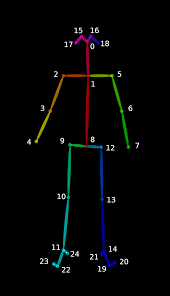

In [ ]:
for name, col in PLOT_COLS.items():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(name,fontsize=24)
    plt.xlabel("frame",fontsize=17)
    plt.ylabel("position",fontsize=17)
    plt.plot(centered_filtered[:,[col*2,]], linestyle="-", linewidth=2.5)
    plt.plot(centered_filtered[:,[col*2+1,]], linestyle="-", linewidth=2.5)
    plt.legend(['x', 'y'],loc=1)

In [12]:
def get_prediction(centered_filtered, col, side = None):
    model = load_model("models/{}_best.pb".format(col))
    correction_model = OLSResults.load("models/{}_correction.pb".format(col))
    maps = {
        "GDI": (25, 100)
    }

    def undo_scaling(y,target_min,target_range):
        return y*target_range+target_min

    preds = []

    video_len = centered_filtered.shape[0]
    
    cols = x_columns
    if side == "L":
        cols = x_columns_left
    if side == "R":
        cols = x_columns_right

    samples = []
    for nstart in range(0,video_len-124,31):
        samples.append(centered_filtered[nstart:(nstart+124),cols])
    X = np.stack(samples)
    
    p = model.predict(X)[:,0]
    p = undo_scaling(p, maps[col][0], maps[col][1])
    p = np.transpose(np.vstack([p,np.ones(p.shape[0])]))
    p = correction_model.predict(pd.DataFrame(p))
    gdi = np.mean(p) 
    pred = res(gdi)

    return pred

0 - No Risk
1 - Risk Found

In [13]:
get_prediction(centered_filtered, "GDI")

0